# RSVQAxBEN


This page describes the usage of Dataloader and Datamodule for [RSVQAxBEN](https://zenodo.org/record/5084904#.ZAsFWNLMIUE), a VQA dataset based on the
{{ben}} Dataset. It was first published by {cite:t}`rsvqaxben`. The dataset can be found on zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.5084904.svg)](https://doi.org/10.5281/zenodo.5084904).
For the usage in this context, the dataset was extended from its RGB form to include all bands originally included in {{ben}}. A small example of the data used is distributed with this package.

This module contains two `classes`, a standard `torch.util.data.Dataset` and a `pytorch_lightning.LightningDataModule` that encapsulates the `Dataset` for easy use in `pytorch_lightning` applications. The `Dataset` uses a `BENLMDBReader` to read images a LMDB file. Questions and Answers are read using JSON files.

In [1]:
# remove-input
# remove-output
import matplotlib.pyplot as plt
import pathlib
from pprint import pprint
import torch
from configilm.extra import data_dir

my_data_path = data_dir.mock_data_path["rsvqaxben"]

/home/leonard/.cache/pypoetry/virtualenvs/configilm-l7TjLRMG-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## RSVQAxBENDataSet

In its most basic form, the `Dataset` only needs the base path of the LMDB file and json files, if the path is not "./". The LMDB file name is assumed to be `BigEarthNetEncoded.lmdb` (note, that from an os point of view, LMDB files are folders). This `Dataset` will load 12 channels (10m + 20m Sentinel-2 + 10m Sentinel-1).

The full folder structure expected for the data is
```
.
├── BigEarthNetEncoded.lmdb
│   ├── data.mdb
│   └── lock.mdb
└── VQA_RSVQAxBEN
    ├── RSVQAxBEN_QA_train.json
    ├── RSVQAxBEN_QA_val.json
    └── RSVQAxBEN_QA_test.json
```

In [2]:
# remove-output
from configilm.extra.DataSets import RSVQAxBEN_DataSet
 
ds = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
    data_dirs=my_data_path  # path to dataset
)

img, question, answer = ds[4]
img = torch.flip(img[:3], [0]) # only choose BGR axis for display and bring into RGB order

Loading split RSVQAxBEN data for None...
          30 QA-pairs indexed
          30 QA-pairs used


/home/leonard/Documents/development/ConfigILM/configilm/extra/DataSets/ClassificationVQADataset.py:144: UserWarning: No tokenizer was provided, using BertTokenizer (uncased). This may result in very bad performance if the used network expected other tokens
  warn(


Size: torch.Size([3, 120, 120])
Question (start): [101, 2024, 6138, 1998, 4568, 8765, 2030, 5424, 2571, 2455, 2556, 1999, 1996, 3746, 1029]
Answer (start): tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


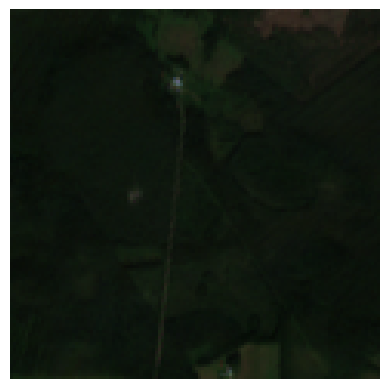

In [3]:
# remove-input
print(f"Size: {img.shape}")
print(f"Question (start): {question[:15]}")
print(f"Answer (start): {answer[:15]}")
# images are 12 bit of radiometric resolution, so to display simply divide by 2^12
# this will not be the best way of displaying but enough as a showcase
img /= 2**12

_ = plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Tokenizer and Tokenization

As we can see, this Dataset uses a tokenizer to generate the Question out of a natural language text. If no tokenizer is provided, a default one will be used, however this may lead to bad performance if not accounted for. The tokenizer can be configured as input parameter.

In [4]:
# remove-output
from configilm.ConfigILM import _get_hf_model

tokenizer, _ = _get_hf_model("prajjwal1/bert-tiny")

ds = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
    data_dirs=my_data_path,  # path to dataset
    tokenizer=tokenizer
)
img, question, answer = ds[0]

Loading split RSVQAxBEN data for None...
          30 QA-pairs indexed
          30 QA-pairs used


:::{tip}
Usually this tokenizer is provided by the model itself as shown in the [VQA example](../../vqa.ipynb) during dataset creation.
:::

During tokenization a sequence of tokens (integers) of specific length is generated. The length of this sequence can be set with the parameter `seq_length`. If the generated tokens are shorter than the sequence length, the sequence will be padded with zeros. If it is longer, the sequence is truncated.
:::{note}
Most tokenizer use an 'End of Sequence' token that will always be the last one in the non-padded sequence.
:::

In [5]:
# remove-output
ds = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
    data_dirs=my_data_path,  # path to dataset
    tokenizer=tokenizer,
    seq_length=16
)
_, question1, _ = ds[0]
print(question1)

Loading split RSVQAxBEN data for None...
          30 QA-pairs indexed
          30 QA-pairs used
[101, 2024, 7976, 2752, 2030, 4910, 2752, 2556, 1029, 102, 0, 0, 0, 0, 0, 0]


In [6]:
# remove-input
print(question1)

[101, 2024, 7976, 2752, 2030, 4910, 2752, 2556, 1029, 102, 0, 0, 0, 0, 0, 0]


In [7]:
# remove-output
ds = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
    data_dirs=my_data_path,  # path to dataset
    tokenizer=tokenizer,
    seq_length=8
)
_, question2, _ = ds[0]
print(question2)

Loading split RSVQAxBEN data for None...
          30 QA-pairs indexed
          30 QA-pairs used
[101, 2024, 7976, 2752, 2030, 4910, 2752, 102]


In [8]:
# remove-input
print(question2)

[101, 2024, 7976, 2752, 2030, 4910, 2752, 102]


The tokenizer can also be used to reconstruct the input/question from the IDs including the special tokens:

In [9]:
print(f"Question 1: '{tokenizer.decode(question1)}'")
print(f"Question 2: '{tokenizer.decode(question2)}'")

Question 1: '[CLS] are artificial areas or agricultural areas present? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'
Question 2: '[CLS] are artificial areas or agricultural areas [SEP]'


or without:

In [10]:
print(f"Question 1: '{tokenizer.decode(question1, skip_special_tokens=True)}'")
print(f"Question 2: '{tokenizer.decode(question2, skip_special_tokens=True)}'")

Question 1: 'are artificial areas or agricultural areas present?'
Question 2: 'are artificial areas or agricultural areas'


### Selecting Bands
Like for the {{ben}} DataSet, this DataSet supports different Band combinations. Currently, the selection is limited to some preconfigured combinations. Which bands are used is defined by the number of channels set in the Dataset. The selection is the same as for the {{ben}} DataSet as we can see when we use a faulty configuration.

In [11]:
# hide-output
try:
    ds = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
        data_dirs=my_data_path,  # path to dataset
        img_size=(-1, 120, 120)
    )
except AssertionError as a:
    print(a)

Image Channels have to be 2 (Sentinel-1), 3 (RGB), 4 (10m Sentinel-2), 10 (10m + 20m Sentinel-2) or 12 (10m + 20m Sentinel-2 + 10m Sentinel-1) but was -1


### Splits

It is possible to load only a specific split (`'train'`, `'val'` or `'test'`) in the dataset. The images loaded are specified using the csv files in the same folder as the LMDB file. By default (`None`), all three are loaded into the same `Dataset`.

In [12]:
# remove-output
_ = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
    data_dirs=my_data_path,  # path to dataset
    split="test",
    tokenizer=tokenizer
)

Loading split RSVQAxBEN data for test...
          10 QA-pairs indexed
          10 QA-pairs used


### Restricting the number of loaded images

It is also possible to restrict the number of images indexed. By setting `max_img_idx = n` only the first `n` images (in alphabetical order based on their S2-name) will be loaded. A `max_img_idx` of  `None`, `-1` or larger than the number of images in the csv file(s) (in this case 25) equals to load-all-images behaviour.

In [13]:
# hide-output
_ = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
    data_dirs=my_data_path,  # path to dataset
    max_len=10,
    tokenizer=tokenizer
)

Loading split RSVQAxBEN data for None...
          30 QA-pairs indexed
          10 QA-pairs used


In [14]:
# hide-output
_ = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
    data_dirs=my_data_path,  # path to dataset
    max_len=100,
    tokenizer=tokenizer
)

Loading split RSVQAxBEN data for None...
          30 QA-pairs indexed
          30 QA-pairs used


### Select Number of Classes or specific Answers

For some applications, it is relevant to have only a certain number of classes as valid output. For example, the `RSVQAxBEN` DataSet could contain up to 2^19 > 0.5 million different classes. To prevent this dimension explosion, the number of classes can be limited. For the 'train' split, it is then automatically determined which combination of classes results in the highest reduction of the dataset.

In [15]:
# hide-output
train_ds = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
    data_dirs=my_data_path,  # path to dataset
    split="train",
    tokenizer=tokenizer,
    num_classes=3
)

Loading split RSVQAxBEN data for train...
          10 QA-pairs indexed
          10 QA-pairs used


These selected answers can be re-used in other splits or limited if only a subset is required.

:::{note}
The number of classes does not necessarily match the number of answers. If there are fewer answers then classes, the last classes will never be encoded in the one-hot encoded answer vector. If there are more, an `IndexError` will happen during accessing a non encode-able element.
:::

In [16]:
# remove-output
print(f"Train DS: {train_ds.answers}")

ds = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
    data_dirs=my_data_path,  # path to dataset
    split="val",
    tokenizer=tokenizer,
    selected_answers=train_ds.answers
)
print(f"Val DS 1: {ds.answers}")

ds = RSVQAxBEN_DataSet.RSVQAxBENDataSet(
    data_dirs=my_data_path,  # path to dataset
    split="val",
    tokenizer=tokenizer,
    selected_answers=train_ds.answers[:2],
)
print(f"Val DS 2: {ds.answers}")

Train DS: ['no', 'yes', 'INVALID']
Loading split RSVQAxBEN data for val...
          10 QA-pairs indexed
          10 QA-pairs used
Val DS 1: ['no', 'yes', 'INVALID']
Loading split RSVQAxBEN data for val...
          10 QA-pairs indexed
          10 QA-pairs used
Val DS 2: ['no', 'yes']


In [17]:
# remove-input
print(f"Train DS: {train_ds.answers}")
print(f"Val DS 1: {ds.answers}")
print(f"Val DS 2: {ds.answers}")

Train DS: ['no', 'yes', 'INVALID']
Val DS 1: ['no', 'yes']
Val DS 2: ['no', 'yes']


## RSVQAxBENDataModule

This class is a Lightning Data Module, that wraps the RSVQAxBENDataSet. It automatically generates DataLoader per split with augmentations, shuffling, etc., depending on the split. All images are resized and normalized and images in the train set additionally basic-augmented via noise and flipping/rotation. The train split is also shuffled, however this can be overwritten (see below).
To use a DataModule, the setup() function has to be called. This populates the Dataset splits inside the DataModule. Depending on the stage ('fit', 'test' or None), the setup will prepare only train & validation Dataset, only test Dataset or all three.

In [18]:
# remove-output
from configilm.extra.DataModules import RSVQAxBEN_DataModule

dm = RSVQAxBEN_DataModule.RSVQAxBENDataModule(
    data_dirs=my_data_path  # path to dataset
)

In [19]:
print("Before:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

Before:
None
None
None


In [20]:
# remove-output
dm.setup(stage="fit")

Loading split RSVQAxBEN data for train...
          10 QA-pairs indexed
          10 QA-pairs used
Loading split RSVQAxBEN data for val...
          10 QA-pairs indexed
          10 QA-pairs used
  Total training samples:       10  Total validation samples:       10


/home/leonard/Documents/development/ConfigILM/configilm/extra/DataSets/ClassificationVQADataset.py:144: UserWarning: No tokenizer was provided, using BertTokenizer (uncased). This may result in very bad performance if the used network expected other tokens
  warn(


In [21]:
print("After:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

After:
None


Afterwards the pytorch `DataLoader` can be easily accessed. Note, that $len(DL) = \lceil \frac{len(DS)}{batch\_size} \rceil$, therefore here with the default `batch_size` of 16: 25/16 -> 2.

In [22]:
train_loader = dm.train_dataloader()
print(len(train_loader))

1


The `DataModule` has in addition to the `DataLoader` settings a parameter each for `data_dir`, `image_size` and `max_img_idx` which are passed through to the `DataSet`.

### DataLoader settings

The `DataLoader` have four settable parameters: `batch_size`, `num_workers_dataloader`, `shuffle` and `pin_memory` with 16, `os.cpu_count()` / 2, `None` and `None` as their default values.

A shuffle of `None` means, that the train set is shuffled but validation and test are not.
Pinned Memory will be set if a `CUDA` device is found, otherwise it will be of. However, this behaviour can be overwritten with `pin_memory`. Changing some of these settings will be accompanied by a Message-Hint printed.

In [23]:
# remove-output
dm = RSVQAxBEN_DataModule.RSVQAxBENDataModule(
    data_dirs=my_data_path,  # path to dataset
    batch_size=4,
    tokenizer=tokenizer
)
dm.setup(stage="fit")

Loading split RSVQAxBEN data for train...
          10 QA-pairs indexed
          10 QA-pairs used
Loading split RSVQAxBEN data for val...
          10 QA-pairs indexed
          10 QA-pairs used
  Total training samples:       10  Total validation samples:       10


In [24]:
print(len(dm.train_dataloader()))

3


In [25]:
# hide-output
_ = RSVQAxBEN_DataModule.RSVQAxBENDataModule(
    data_dirs=my_data_path,  # path to dataset
    shuffle=False
)

/home/leonard/Documents/development/ConfigILM/configilm/extra/DataModules/ClassificationVQADataModule.py:104: UserWarning: Shuffle was set to False. This is not recommended for most configuration. Use shuffle=None (default) for recommended configuration.
  warn(


In [26]:
# hide-output
_ = RSVQAxBEN_DataModule.RSVQAxBENDataModule(
    data_dirs=my_data_path,  # path to dataset
    num_workers_dataloader=2
)

In [27]:
# hide-output
_ = RSVQAxBEN_DataModule.RSVQAxBENDataModule(
    data_dirs=my_data_path,  # path to dataset
    pin_memory=False
)